Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pydicom
import os
import pylab

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.display import display
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

%matplotlib inline

sb.set_style('darkgrid', {'axes.grid' : False})
my_dpi = 96

# CT Medical Image Feature Extraction


## Question:
Can a Restricted Boltzmann Machine(RBM) increase the accuracy of image classification, more specifically does feature extraction employing RBM increase the accuracy of predicting whether a CT image has contrast or not?

### Data:
Meta-data and image data taken from [Kaggle](https://www.kaggle.com/kmader/siim-medical-image-analysis-tutorial). 

The imaging data are a tiny subset of images from the cancer imaging archive. They consist of the middle slice of all CT images taken where valid age, modality, and contrast tags could be found. This results in 475 series from 69 different patients.

The computed tomography (CT)  data comes from the [Cancer Imaging Archive site](http://www.cancerimagingarchive.net/)
  


### Context:
The dataset is designed to allow for different methods to be tested for examining the trends in CT image data associated with using contrast and patient age. The basic idea is to identify image textures, statistical patterns and features correlating strongly with these traits and possibly build simple tools for automatically classifying these images when they have been misclassified (or finding outliers which could be suspicious cases, bad measurements, or poorly calibrated machines).

### Content:

+ Age : The age of the patient at the time the CT scan was carried out.

+ Contrast : Boolean value indicating whether the patient was given contrast before the CT scan.

+ ContrastTag : Contents of DICOM tag, very unreliable at some scan centers and hospital especially during the 80’s and 90’s.

+ Raw Input Path : Relative file path to DICOM file if data was down loaded.

+ Id : Identifier of Patient during study.

+ Tiff Name : File name of image that contains patient’s id, age and whether slice comes a scan where contrast was administered.

+ DICOM Name : File name of image that contains patient’s id, age and whether slice comes a scan where contrast was administered.


In [2]:
# Read CSV containing meta data on image data
root_path = '/media/ianh/space/ThinkfulData/MedicalImaging/CT/CT_Medical_IA'
root_path += os.sep
img_file = root_path + 'full_archive.npz'
csv_file = root_path + 'overview.csv'
meta_data = pd.read_csv(csv_file)
print("\nNumber of Observations : %d\n" % (meta_data.shape[0]))
print("Number of Features : %d\n" % (meta_data.shape[1]))


Number of Observations : 100

Number of Features : 7



### Preprocessing and exploratory data analysis

In [3]:
# Check for missing data
print("%s\n" % (meta_data.isnull().sum()))

# Lets ensure that all columns are of the expected type object and int (or float)
print("\n%s\n" % (meta_data.dtypes))
meta_data.head()

Age               0
Contrast          0
ContrastTag       2
raw_input_path    0
id                0
tiff_name         0
dicom_name        0
dtype: int64


Age                int64
Contrast            bool
ContrastTag       object
raw_input_path    object
id                 int64
tiff_name         object
dicom_name        object
dtype: object



,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


We now load all the pixel data from numpy arrays persisted on disk.  One slice of a 512 x 512 CT image is displayed to show what the imaging data looks like.  One slice from each patients data is available, but the slice used for each patient will be different and it is assumed that the same portion of anatomy was scanned. 
This is an important assumption, the use of contrast will be more apparent for organs than bones. So a slice that displays a larger portion of an organ will be much brighter than a slice from the same patient collected higher in the torso. 

475 number of slices loaded from frozen numpy arrays



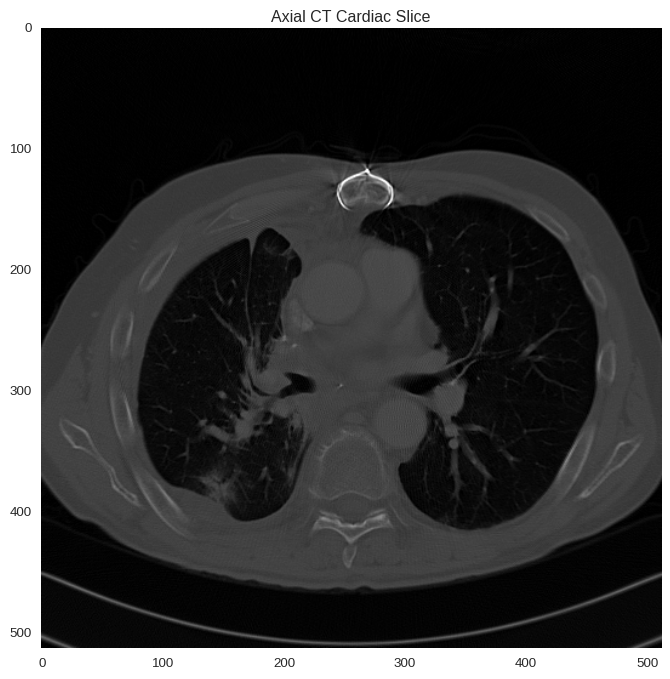

In [4]:
with np.load(img_file) as im_data:
    # make a dictionary of the data vs idx
    full_image_dict = dict(zip(im_data['idx'], im_data['image']))
    
print('%d number of slices loaded from frozen numpy arrays\n' % (len(full_image_dict)))

# display the first image in the data set
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title("Axial CT Cardiac Slice")
__= pylab.imshow(full_image_dict[0], cmap=pylab.cm.gray)

In [5]:
# Timing context manager for statement invocations.
# Taken from Python Cookbook section 14.13
import time

from contextlib import contextmanager
@contextmanager
def timeblock(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print('{} : {:.2f} secs'.format(label, end - start))


### Feature Creation

The Hounsfield unit (HU) scale is a linear transformation of the original linear attenuation coefficient measurement into one in which the radiodensity of distilled water. This scale is used in Computed Topography (CT) .  Body substances have a known range of Hounsfield units in the ideal case.  There are many factors that can contribute to variations to the ranges below such as machine calibration.  A set of new features will be created based on the percentage of body substance within each patient’s slice.  Below is a listing of the body substance percentage that will be computed including the HU range of each substance. 

Substance 	HU

Lung 	-700 to −600

Fat 	−120 to −90

Bile 	-5 to +15

Kidney 	+20 to +45

Liver 	+40 to +60

Soft Tissue, Contrast 	+100 to +300

Bone 	+700 (cancellous bone) to +3000 (cortical bone)

In [6]:
# Drop image path features from data set
meta_data = meta_data.drop(['raw_input_path', 'tiff_name', 'dicom_name'], axis=1)

numberof_pixels_slice = 512 * 512

empty_slice = np.zeros((512,512))

def range(x, axis=0):
    return np.max(np.max(x, axis=axis)) - np.min(np.min(x, axis=axis))


def cal_percentage(x, max, min):
    return (np.sum((min < x) & (x > max)) / numberof_pixels_slice)

meta_data['MeanHU'] = meta_data['id'].map(lambda x: np.mean(full_image_dict.get(x, empty_slice)))
meta_data['StdHU'] = meta_data['id'].map(lambda x: np.std(full_image_dict.get(x, empty_slice)))
meta_data['RangeHU'] = meta_data['id'].map(lambda x: range(full_image_dict.get(x, empty_slice)))
meta_data['MaxHU'] = meta_data['id'].map(lambda x: np.max(np.max(full_image_dict.get(x, empty_slice), axis=0)))
meta_data['MinHU'] = meta_data['id'].map(lambda x: np.min(np.min(full_image_dict.get(x, empty_slice), axis=0)))

# Create some new features based on percentage of pixels
# over the range of Hounsfield units for common body substances 

meta_data['LungRange'] = meta_data['id'].map(lambda x: cal_percentage(full_image_dict.get(x, empty_slice), -700, -600))
meta_data['FatRange'] = meta_data['id'].map(lambda x: cal_percentage(full_image_dict.get(x, empty_slice), -120, -90))
meta_data['BileRange'] = meta_data['id'].map(lambda x: cal_percentage(full_image_dict.get(x, empty_slice), -5, 15))
meta_data['KidneyRange'] = meta_data['id'].map(lambda x: cal_percentage(full_image_dict.get(x, empty_slice), 20, 45))
meta_data['LiverRange'] = meta_data['id'].map(lambda x: cal_percentage(full_image_dict.get(x, empty_slice), 40, 60))
meta_data['SoftTissueConRange'] = meta_data['id'].map(lambda x: cal_percentage(full_image_dict.get(x, empty_slice), 100, 300))
meta_data['BoneRange'] = meta_data['id'].map(lambda x: cal_percentage(full_image_dict.get(x, empty_slice), 700, 3000))

# Lastly we create the target variable from the Contrast feature
meta_data['y'] = np.where(meta_data.Contrast == True, 1, 0)
meta_data.head()

,Age,Contrast,ContrastTag,id,MeanHU,StdHU,RangeHU,MaxHU,MinHU,LungRange,FatRange,BileRange,KidneyRange,LiverRange,SoftTissueConRange,BoneRange,y
0,60,True,NONE,0,-539.466618,481.395926,4095.0,3071.0,-1024.0,0.418430,0.323708,0.199158,0.147594,0.123318,0.015743,0.000198,1
1,69,True,NONE,1,-528.569126,476.256917,4095.0,3071.0,-1024.0,0.430782,0.340435,0.216976,0.162064,0.127548,0.011909,0.000027,1
2,74,True,APPLIED,2,-604.697800,479.019832,4095.0,3071.0,-1024.0,0.363388,0.289661,0.193558,0.146030,0.103207,0.010845,0.000053,1
3,75,True,NONE,3,-539.298073,501.380886,1987.0,963.0,-1024.0,0.442326,0.395706,0.239666,0.188210,0.154613,0.004189,0.000000,1
4,56,True,NONE,4,-528.569126,476.256917,4095.0,3071.0,-1024.0,0.430782,0.340435,0.216976,0.162064,0.127548,0.011909,0.000027,1


In [7]:
meta_data.Contrast.value_counts()

True     50
False    50
Name: Contrast, dtype: int64

In [8]:
# remove DICOM tag feature, Essentially a duplicate of feature contrast,
# not to mention that some scanners put junk in these tags. 
print(meta_data.ContrastTag.value_counts())
meta_data = meta_data.drop(['ContrastTag', 'Contrast', 'id'], axis=1)

meta_data.tail()

NONE                        86
APPLIED                      5
100 ML OPTI 350              2
O                            1
ISOVUE                       1
REDI CAT & 125CC OPTIRAY     1
125CC OPTIRAY                1
&                            1
Name: ContrastTag, dtype: int64


,Age,MeanHU,StdHU,RangeHU,MaxHU,MinHU,LungRange,FatRange,BileRange,KidneyRange,LiverRange,SoftTissueConRange,BoneRange,y
95,71,-556.311596,508.374124,2784.0,1760.0,-1024.0,0.394154,0.340408,0.267910,0.235081,0.214363,0.021164,0.000000,0
96,83,-604.487186,482.233825,4095.0,3071.0,-1024.0,0.339382,0.287640,0.207531,0.168907,0.134029,0.022541,0.000015,0
97,60,-500.564774,518.125952,2395.0,1371.0,-1024.0,0.453606,0.407379,0.306274,0.270195,0.241882,0.010551,0.000000,0
98,61,-593.347729,452.088311,1943.0,919.0,-1024.0,0.360229,0.289574,0.189026,0.157574,0.137459,0.007435,0.000000,0
99,61,-594.047462,465.681820,3306.0,2282.0,-1024.0,0.367401,0.291191,0.190334,0.153320,0.105282,0.012520,0.000000,0


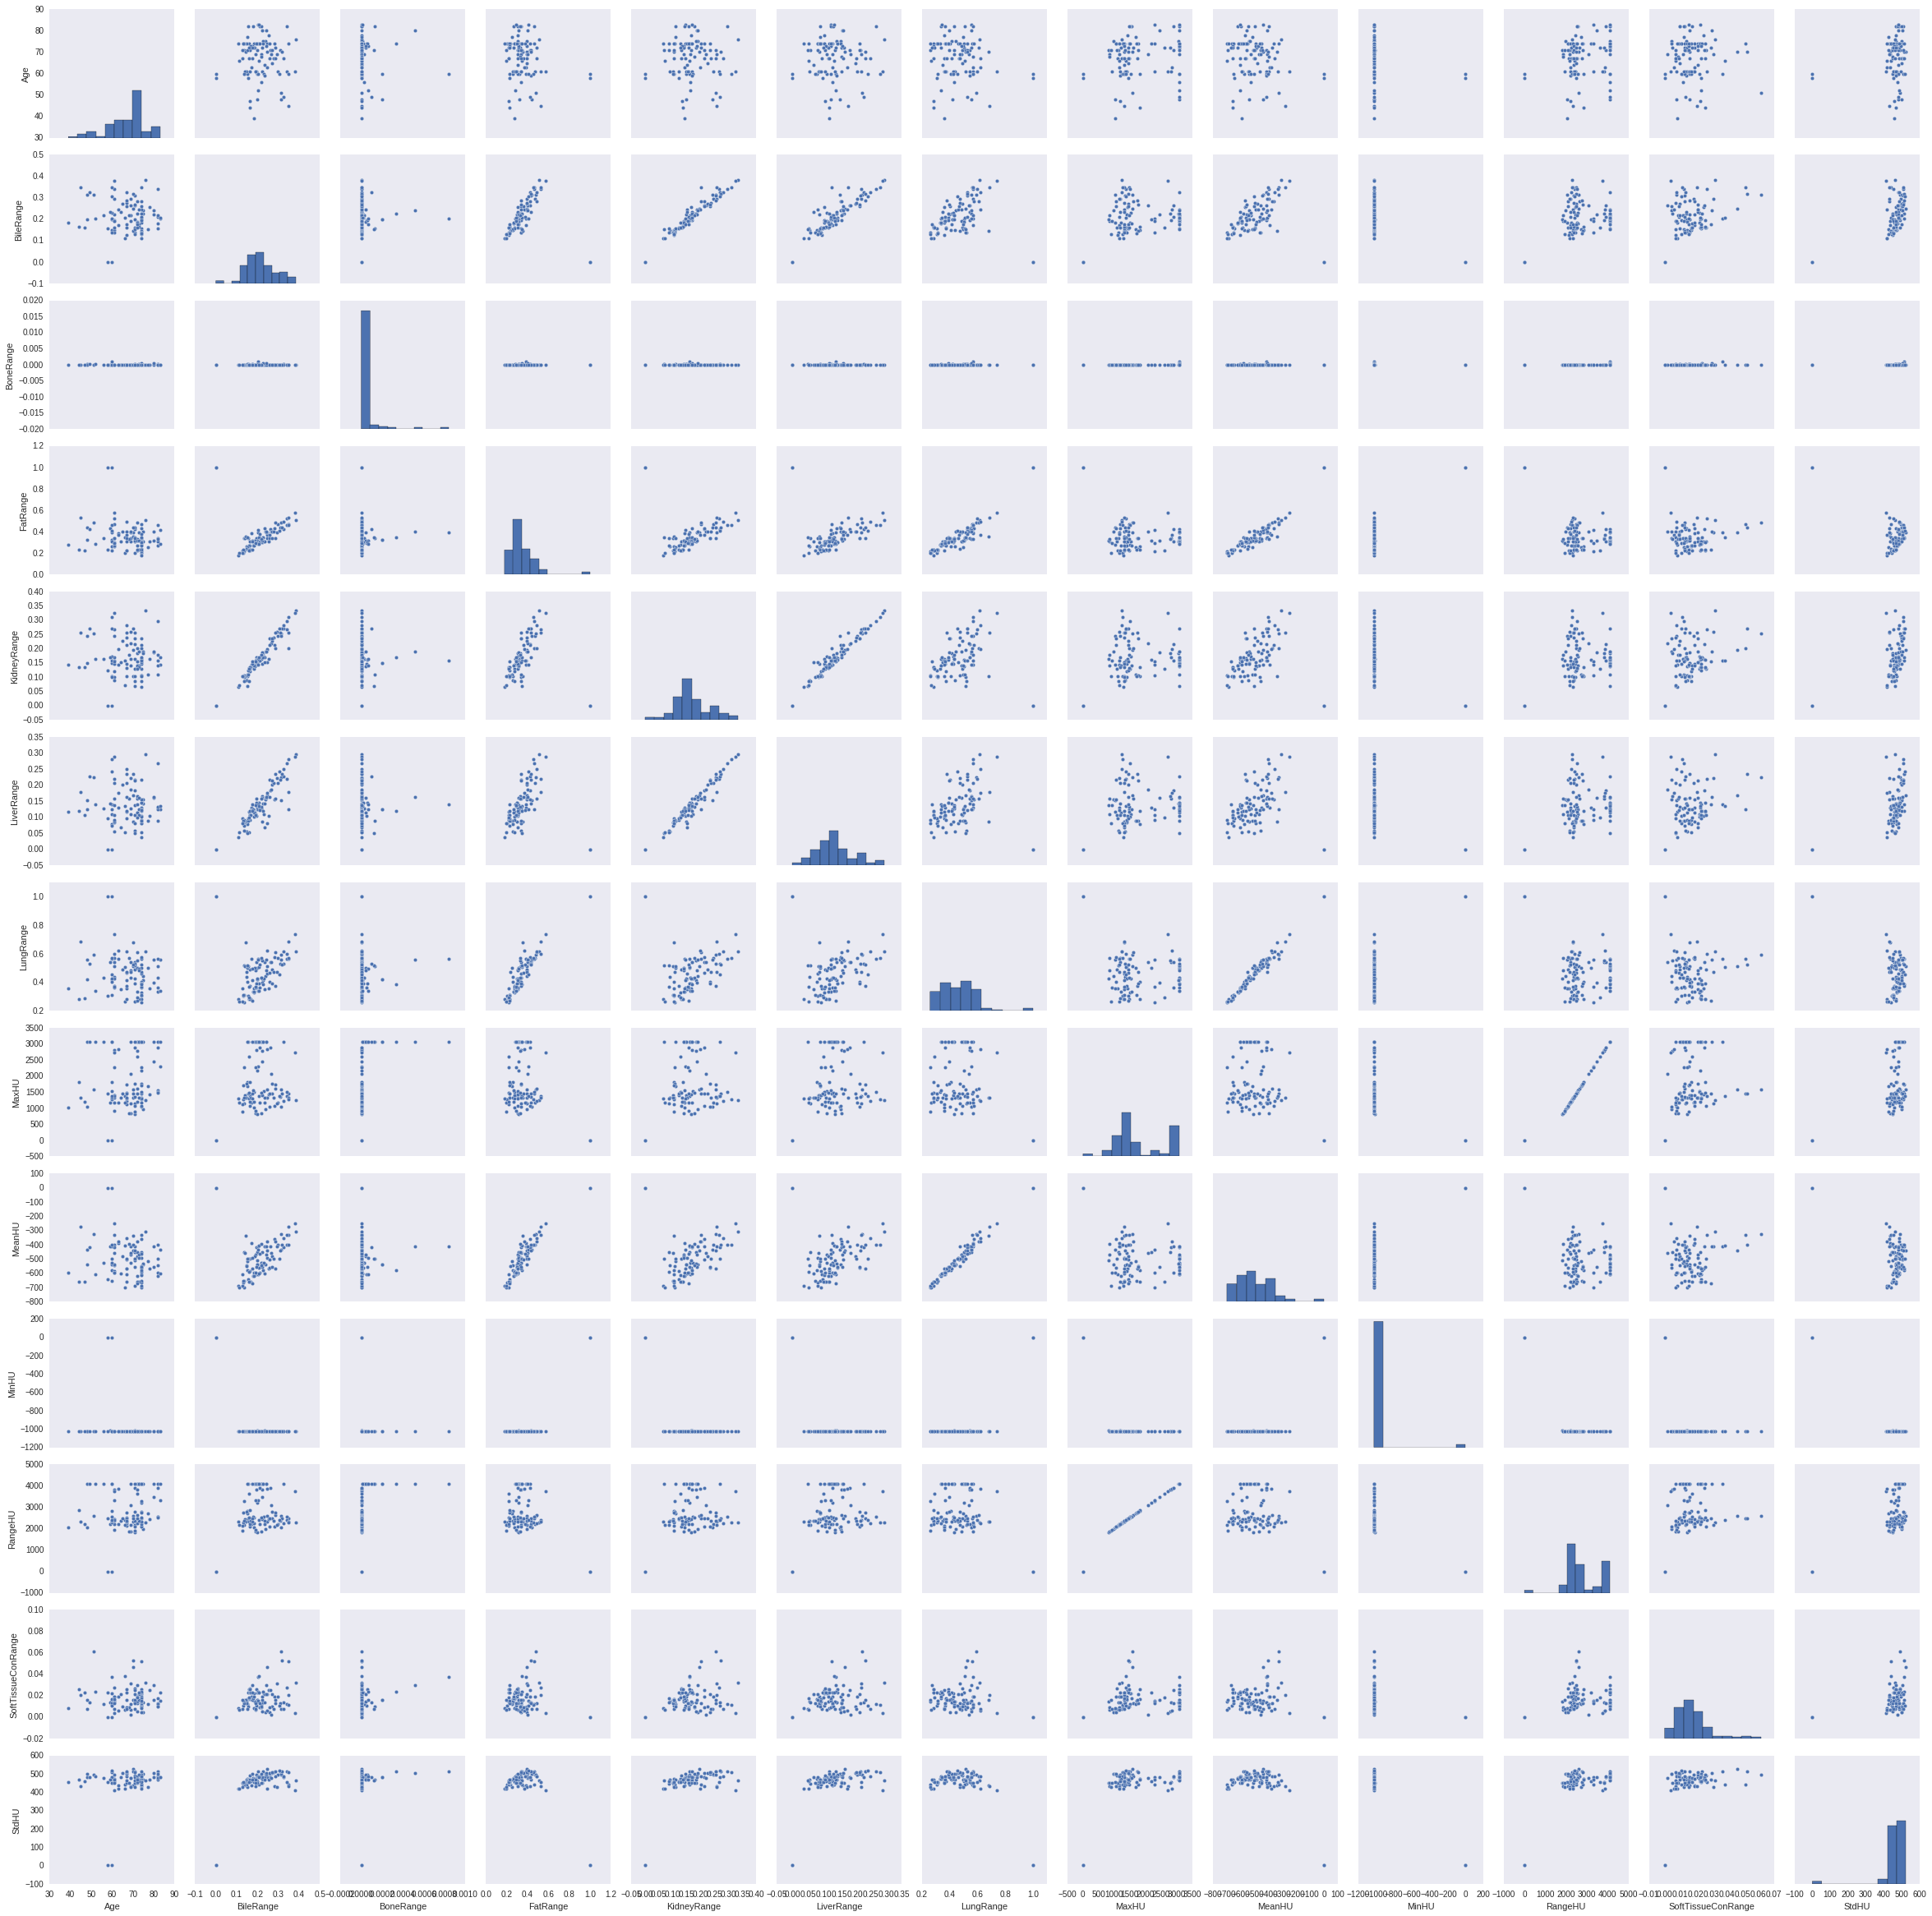

In [9]:
exclude = ['y']
__ = sb.pairplot(meta_data.ix[:, meta_data.columns.difference(exclude)])

## Feature Extraction and Model Building


### Using the Restricted Boltzmann Machine

Time Spent training pipeline : 0.04 secs


[0 1]
             precision    recall  f1-score   support

No Contrast       0.67      0.67      0.67        15
   Contrast       0.67      0.67      0.67        15

avg / total       0.67      0.67      0.67        30





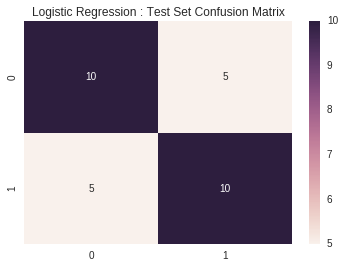

In [26]:
from sklearn.metrics import classification_report

y = meta_data.y
X = meta_data.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0)
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000.0

# Lets not forget to Standardize the features
pipe_classifier = Pipeline(steps=[('scl', StandardScaler()), ('rbm', rbm), ('logistic', logistic)])


# Training RBM-Logistic Pipeline
with timeblock('Time Spent training pipeline'):
    pipe_classifier.fit(X_train, y_train)
    
y_ = pipe_classifier.predict(X_test)

print('\n')
print(logistic.classes_)
target_names = ['No Contrast', 'Contrast']
print(classification_report(y_test, y_, target_names=target_names))
print('\n')
cnfsn_mtrx = metrics.confusion_matrix(y_test, y_)

# Display heatmap of confusion matrix
_ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
_ = plt.title("Logistic Regression : Test Set Confusion Matrix")

### Without Restricted Boltzmann Machine

Time Spent training pipeline : 0.00 secs


[0 1]
             precision    recall  f1-score   support

No Contrast       0.55      0.73      0.63        15
   Contrast       0.60      0.40      0.48        15

avg / total       0.57      0.57      0.55        30





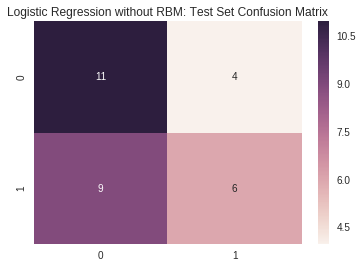

In [27]:
y = meta_data.y
X = meta_data.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression()
logistic.C = 6000.0

# Lets not forget to Standardize the features
pipe_classifier = Pipeline(steps=[('scl', StandardScaler()), ('logistic', logistic)])


# Training Logistic Pipeline
with timeblock('Time Spent training pipeline'):
    pipe_classifier.fit(X_train, y_train)
    
y_ = pipe_classifier.predict(X_test)

print('\n')
print(logistic.classes_)
target_names = ['No Contrast', 'Contrast']
print(classification_report(y_test, y_, target_names=target_names))
print('\n')
cnfsn_mtrx = metrics.confusion_matrix(y_test, y_)

# Display heatmap of confusion matrix
_ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
_ = plt.title("Logistic Regression without RBM: Test Set Confusion Matrix")

## Discussion

Unfortunately, there is too few observations for this Kaggle data set.  More patients are needed for the RBM and logistic regression to be of any use in a real-world setting.  In addition, another limitation of the data is that it is unclear whether slice location was controlled for. As mentioned previously, the use of contrast will be more apparent for organs than bones.  A slice that displays a larger portion of an organ will be much brighter than a slice from the same patient collected higher in the torso. The contrast solution is not carried through or absorbed by Soft tissue and bone. 

Two different executions of pipelines where run. The first pipeline includes standardization, RBM and logistic regression. The second pipeline excludes the neural network for feature extraction. 

The first pipeline has a marginally higher f1 score with higher sensitivity and specificity when compared to the results of the second pipeline without RBM.  The second pipeline has a misclassification rate of 50 %, in other words it incorrectly classified half of the testing data.  The first pipeline’s misclassification rate is 33 % not great but better than the pipeline without the use of the Restricted Boltzmann Machine. 